In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ineskellou_image_coloriser_data_path = kagglehub.dataset_download('ineskellou/image-coloriser-data')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-coloriser-data/dataset/Test/ck9097.jpg
/kaggle/input/image-coloriser-data/dataset/Test/eLTOPl.jpg
/kaggle/input/image-coloriser-data/dataset/Test/Fiv4Ae.jpg
/kaggle/input/image-coloriser-data/dataset/Test/6mWRzQ.jpg
/kaggle/input/image-coloriser-data/dataset/Test/photo-1485618609651-5a8bd6efc777.jpeg
/kaggle/input/image-coloriser-data/dataset/Test/1CMFw8.jpg
/kaggle/input/image-coloriser-data/dataset/Test/photo-1492070613324-18a52223e22b.jpeg
/kaggle/input/image-coloriser-data/dataset/Test/FZSoqz.jpg
/kaggle/input/image-coloriser-data/dataset/Test/641kuT.jpg
/kaggle/input/image-coloriser-data/dataset/Test/AeZQOa.jpg
/kaggle/input/image-coloriser-data/dataset/Test/photo-1453701893258-ba854a03e726.jpeg
/kaggle/input/image-coloriser-data/dataset/Test/0fAtAB.jpg
/kaggle/input/image-coloriser-data/dataset/Test/HI3QAc.jpg
/kaggle/input/image-coloriser-data/dataset/Test/Anm3IE.jpg
/kaggle/input/image-coloriser-data/dataset/Test/hheW19.jpg
/kaggle/input/image-coloriser-data

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
soaipath_test = "/kaggle/input/image-coloriser-data/dataset/Test"
soaipath_train = "/kaggle/input/image-coloriser-data/dataset/Train"

IMG_SIZE = (32, 32)
BATCH_SIZE = 64

In [ ]:
def load_image_paths(directory):
    return [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.lower().endswith(('png', 'jpg', 'jpeg'))]

In [ ]:
train_paths = load_image_paths(soaipath_train)
test_paths = load_image_paths(soaipath_test)
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train_cifar, _), (x_test_cifar, _) = cifar10.load_data()
images_cifar = tf.convert_to_tensor(x_train_cifar, dtype=tf.uint8)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print(f"Number of training images: {len(train_paths)}")
print(f"Number of test images: {len(test_paths)}")

Number of training images: 9196
Number of test images: 486


In [ ]:
i = np.array(Image.open(train_paths[0]).convert("RGB"))
print(i.shape)

(256, 256, 3)


In [ ]:
def is_greyscale(img):
    if img.mode == "L":
        return True
    if img.mode == "RGB":
        r, g, b=img.split()
        return r==b and b==g
    return False

In [ ]:
def load_process(path, target_size=IMG_SIZE):
    img = Image.open(path).convert("RGB").resize(target_size)
    return np.array(img)

In [ ]:
grey = []
coloured = []
for path in train_paths:
    img = Image.open(path)
    if is_greyscale(img):
        grey.append(load_process(path))
    else:
        coloured.append(load_process(path))

images = tf.convert_to_tensor(coloured, dtype=tf.uint8)

KeyboardInterrupt: 

In [ ]:
all_images = tf.concat([images_cifar, images], axis=0)

In [ ]:
 def convert_to_lab(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image)
    l = l / 255.0
    a = (a - 128.0) / 128.0
    b = (b - 128.0) / 128.0
    return l[..., np.newaxis], np.stack((a, b), axis=-1)


l_channel, ab_channel = [], []
for image in all_images.numpy():
    l, ab=convert_to_lab(image)
    l_channel.append(l)
    ab_channel.append(ab)

train_input = np.array(l_channel, dtype=np.float32)
supposed_ouput=np.array(ab_channel, dtype=np.float32)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, supposed_ouput))
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_images = tf.convert_to_tensor(coloured, dtype=tf.uint8)

In [ ]:
l_channel_test, ab_channel_test = [], []
for image in test_images.numpy():
    l, ab=convert_to_lab(image)
    l_channel_test.append(l)
    ab_channel_test.append(ab)

test_l = np.array(l_channel_test, dtype=np.float32)
test_ab=np.array(ab_channel_test, dtype=np.float32)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


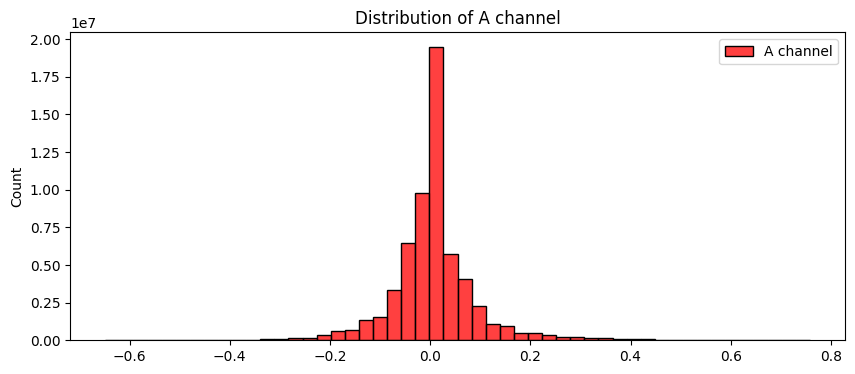

In [ ]:
import seaborn as sns

a_vals = supposed_ouput[..., 0].flatten()
plt.figure(figsize=(10, 4))
sns.histplot(a_vals, bins=50, color='r', label='A channel')
plt.legend()
plt.title("Distribution of A channel")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


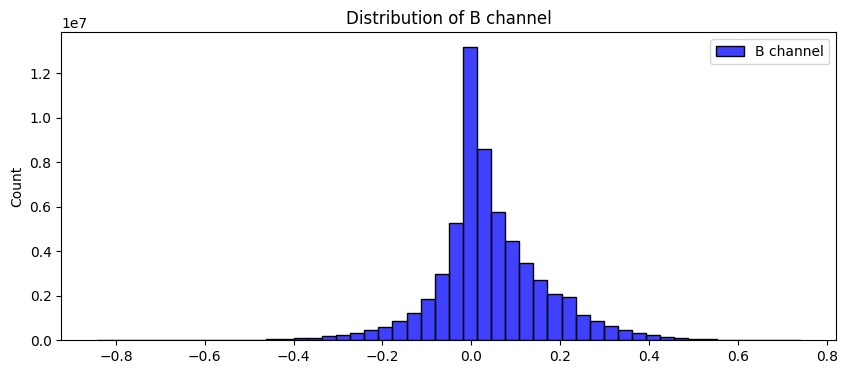

In [ ]:
b_vals = supposed_ouput[..., 1].flatten()
plt.figure(figsize=(10, 4))
sns.histplot(b_vals, bins=50, color='b', label='B channel')
plt.legend()
plt.title("Distribution of B channel")
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer

model = Sequential([
    InputLayer(input_shape=(32, 32, 1)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    UpSampling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(2, (3,3), activation='tanh', padding='same'),
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 2)           │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,026 (1.13 MB)

 Trainable params: 297,026 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [ EarlyStopping(monitor="loss", patience=3, verbose=1), ReduceLROnPlateau(monitor='loss')]

In [ ]:
model.fit(train_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0099 - learning_rate: 0.0010
Epoch 2/20
 13/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0104

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0099 - learning_rate: 0.0010
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 6/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 7/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 8/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 9/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 10/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 11/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 12/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0097 - learnin

In [ ]:
predicted_ab = model.predict(test_l)

287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
import numpy as np

def psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(2.0) - 10 * np.log10(mse)

psnr_score = psnr(test_ab, predicted_ab)
print("PSNR:", psnr_score)


PSNR: 26.42006547419271


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_ab.reshape(len(test_ab), -1),
                          predicted_ab.reshape(len(predicted_ab), -1))
print("MAE:", mae)


MAE: 0.060642637


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_ab.reshape(len(test_ab), -1),
                         predicted_ab.reshape(len(predicted_ab), -1))
print("MSE:", mse)


MSE: 0.009121217


In [ ]:
def lab_to_rgb(l, ab):
    if l.shape[-1] == 1:
        l = l[..., 0]

    a = ab[..., 0]
    b = ab[..., 1]

    l = l * 255.0
    a = a * 128.0 + 128.0
    b = b * 128.0 + 128.0

    lab_image = np.stack((l, a, b), axis=-1).astype(np.uint8)  # shape: (32, 32, 3)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
    return rgb_image


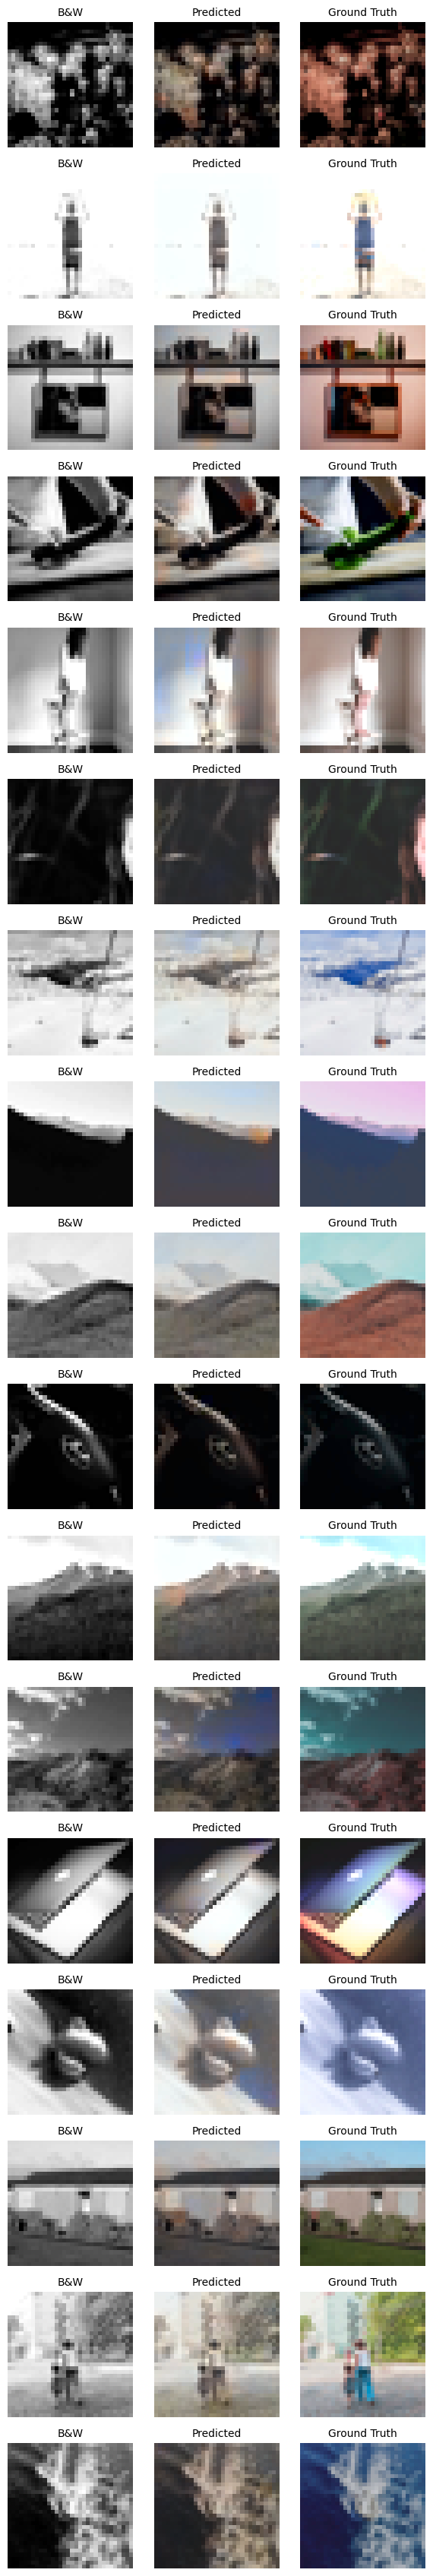

In [ ]:
import matplotlib.pyplot as plt

num_images = 17
cols = 3  # B&W, Predicted, Ground Truth
rows = num_images

plt.figure(figsize=(6, rows * 2))  # Adjust height for spacing

for i in range(num_images):
    input_l = test_l[i]
    true_ab = test_ab[i]
    pred_ab = predicted_ab[i]

    gray_img = np.squeeze(input_l) * 255.0
    predicted_rgb = lab_to_rgb(input_l, pred_ab)
    true_rgb = lab_to_rgb(input_l, true_ab)

    # B&W
    ax = plt.subplot(rows, cols, i * cols + 1)
    ax.imshow(gray_img, cmap='gray')
    ax.set_title("B&W", fontsize=10)
    ax.axis("off")

    # Predicted
    ax = plt.subplot(rows, cols, i * cols + 2)
    ax.imshow(predicted_rgb)
    ax.set_title("Predicted", fontsize=10)
    ax.axis("off")

    # Ground Truth
    ax = plt.subplot(rows, cols, i * cols + 3)
    ax.imshow(true_rgb)
    ax.set_title("Ground Truth", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


<ipython-input-77-f42d64ef0ca9>:29: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


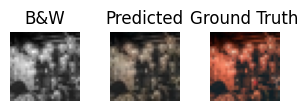

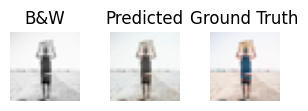

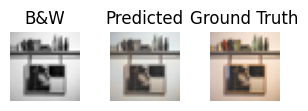

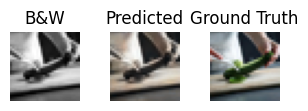

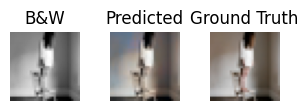

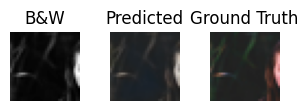

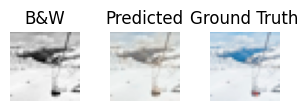

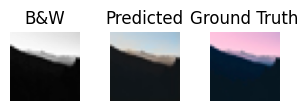

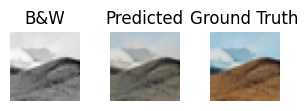

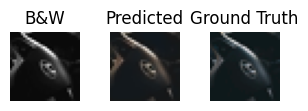

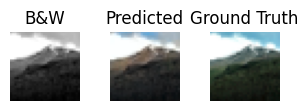

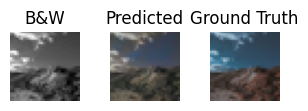

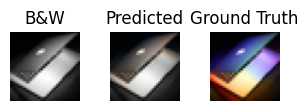

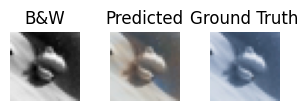

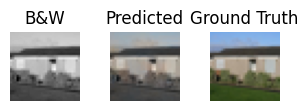

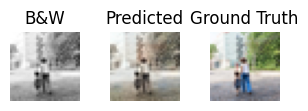

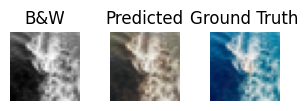

In [ ]:
import random

for i in range(17):
    input_l = test_l[i]
    true_ab = test_ab[i]
    pred_ab = predicted_ab[i]

    gray_img = np.squeeze(input_l) * 255.0  # Original grayscale
    predicted_rgb = lab_to_rgb(input_l, pred_ab)
    true_rgb = lab_to_rgb(input_l, true_ab)

    plt.figure(figsize=(3, 1))

    plt.subplot(1, 3, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.title("B&W")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_rgb)
    plt.title("Predicted")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    plt.show()

In [ ]:
rgb_output = lab_to_rgb(l, preds)
plt.subplot(1, 2, 1)
plt.imshow(rgb_output)
plt.title("Colorized output")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title("Original image")
plt.axis("off")

plt.show()


NameError: name 'preds' is not defined

In [ ]:
def display_normalized_lab_channels(l_normalized, ab_normalized):
    # Un-normalize
    l = l_normalized[..., 0] * 255.0
    a = (ab_normalized[..., 0] * 128.0) + 128.0
    b = (ab_normalized[..., 1] * 128.0) + 128.0

    l_display = l.astype(np.uint8)
    a_display = a.astype(np.uint8)
    b_display = b.astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(l_display, cmap='gray')
    plt.title('L Channel')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(a_display)
    plt.title('A Channel')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(b_display)
    plt.title('B Channel')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

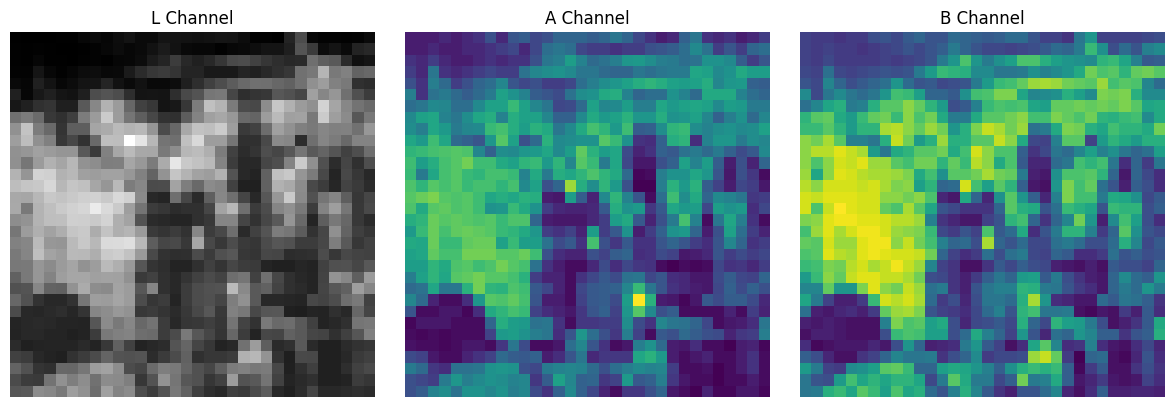

In [ ]:
img = Image.open(train_paths[0]).convert("RGB").resize((32, 32))
rgb_img = np.array(img)

l, ab = convert_to_lab(rgb_img)
display_normalized_lab_channels(l, ab)